# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV

from sklearn.feature_selection import RFE

import optuna

from sklearn.model_selection import cross_val_score

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df_bank = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
df_bank.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

Исследуем данные на предмет пропусков

In [4]:
df_bank.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

В ходе анализа данных видим 25 **пропусков** в признаке **balance**. Возможно в других признаках есть пропущенные значения, обозначенные иначе, чем NaN

### Задание 2

In [5]:
df_bank.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В признаке job обнаружена категория **'unknown'** в количестве **70**, которую можно трактовать, как **пропуск**

### Задание 3

**Преобразуем** признак 'balance' в вещественное число, используя регулярные выражения и replace

In [6]:
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df_bank['balance'] = df_bank['balance'].apply(make_convert)

In [7]:
df_bank.info()
round(df_bank.balance.mean(), 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


1529.129

### Задание 4

Обработаем пропуски в признаке **balance**, заменив их на медианные значения по данному признаку

In [8]:
df_bank.balance = df_bank.balance.fillna(df_bank.balance.median())
round(df_bank.balance.mean(), 3)

1526.936

### Задание 5

Обработаем пропуски в категориальных признаках: **job и education**, заменив их на **модальные** значения

In [9]:
df_bank.job = df_bank.job.apply(lambda x: np.nan if x == 'unknown' else x).fillna(df_bank.job.mode()[0])
df_bank.education = df_bank.education.apply(lambda x: np.nan if x == 'unknown' else x).fillna(df_bank.education.mode()[0])

In [10]:
m_job = df_bank['job'].mode()[0]
m_edu = df_bank['education'].mode()[0]
round(df_bank[(df_bank.job == m_job) & (df_bank.education == m_edu)]['balance'].mean(), 3)


1598.883

### Задание 6

Проверим признак **balance** на выбросы

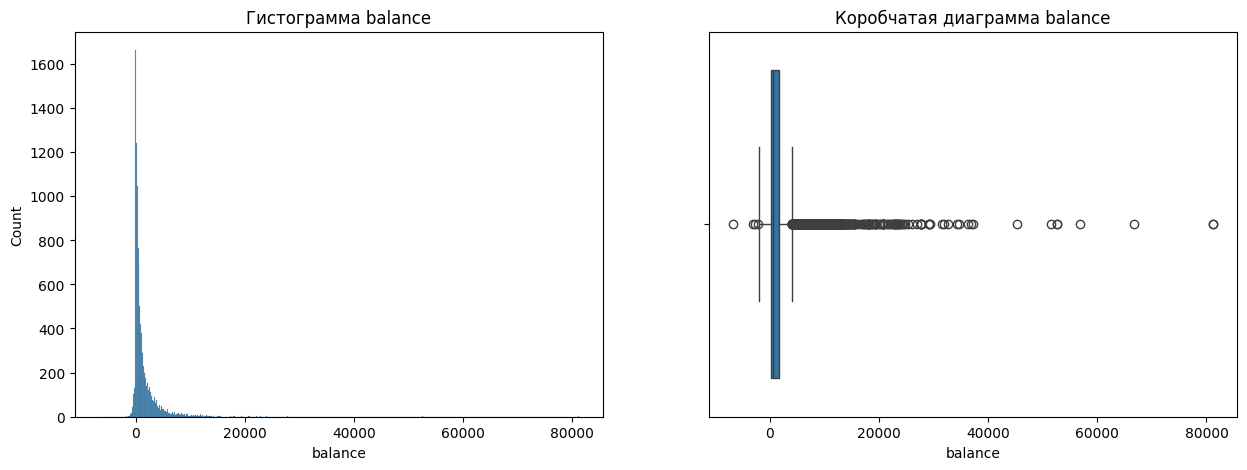

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
hisplot = sns.histplot(df_bank, x='balance', ax=axes[0]);
hisplot.set_title('Гистограмма balance');
boxplot = sns.boxplot(df_bank, x='balance', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма balance');

Диаграммы признака balance сильно **сплюснуты**, что говорит о наличии **выбросов** в признаке. Для удаления выбросов восполбзуемся методом **Тьюки**

In [12]:
# напишим функцию для отлавливания выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print(round(lower_bound))
    upper_bound = quartile_3 + (iqr * 1.5)
    print(round(upper_bound))
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr(df_bank, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241
4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [13]:
df_bank = df_bank[(df_bank['balance'] >= -2241) & (df_bank['balance'] <= 4063)]

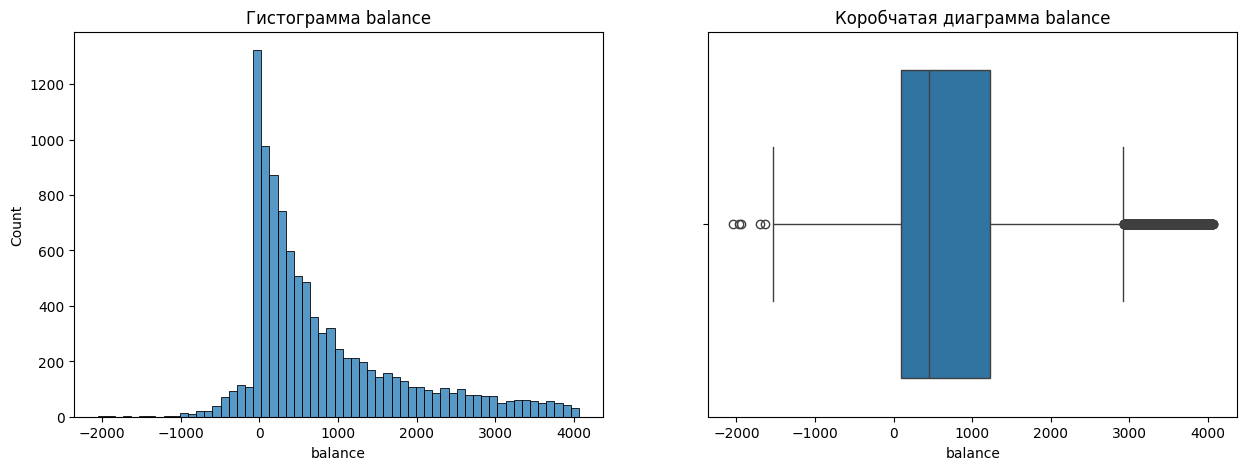

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
hisplot = sns.histplot(df_bank, x='balance', ax=axes[0]);
hisplot.set_title('Гистограмма balance');
boxplot = sns.boxplot(df_bank, x='balance', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма balance');

После примененения метода **Тьюки** данные стали более **нормально** распределены, но выбросы все равно **остались**

## Часть 2:  Разведывательный анализ

### Задание 1

Изучим соотношение классов в данных на предмет **несбалансированности**

In [15]:
deposit_values = df_bank.deposit.value_counts(normalize=True)
deposit_values

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

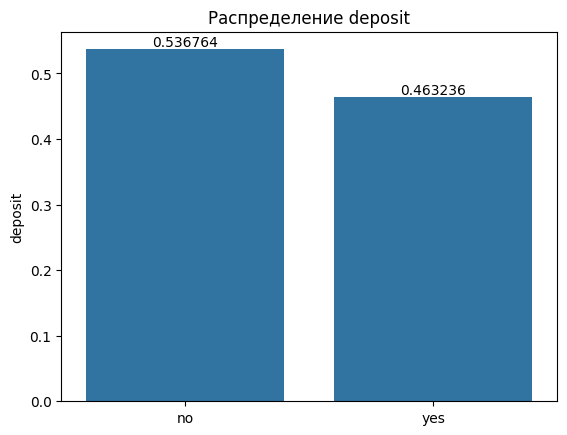

In [16]:
ax = sns.barplot(deposit_values, orient='v');
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_title('Распределение deposit');

Классы целевой переменной **несбалансированы** (незначительное отличие)

### Задания 2 и 3

In [17]:
df_bank.head(3)

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no   2343.0     yes   no  unknown   
1   56      admin.  married  secondary      no     45.0      no   no  unknown   
2   41  technician  married  secondary      no   1270.0     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes

Рассчитаем **описательные статистики** для количественных переменных, проинтерпретируйте результат

In [18]:
df_bank.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

 - Бросается в глаза максимальный возраст клиента - **95 лет**, его можно отнести к **выбросу**, но таких выбросов не много, поскольку медиана и среднее значение в признаке незначительно отличаются;
 - Также заметна **разница** между медианой и средним в признаке **balance** (почти **в 2 раза**);
 - Огромная **разница** между медианой и средним в признаке **pdays** однозначно говорит о значительном количестве выбросов. Ну и количество пропущенных дней **вряд ли может быть отрицательным**, здесь минимум **не должен быть меньше нуля**.
 - Аномально распределены данные и в признаке previous(**минимум и медиана равны 0**, максимум - 58), что говорит о **выбросах**.

<Figure size 640x480 with 0 Axes>

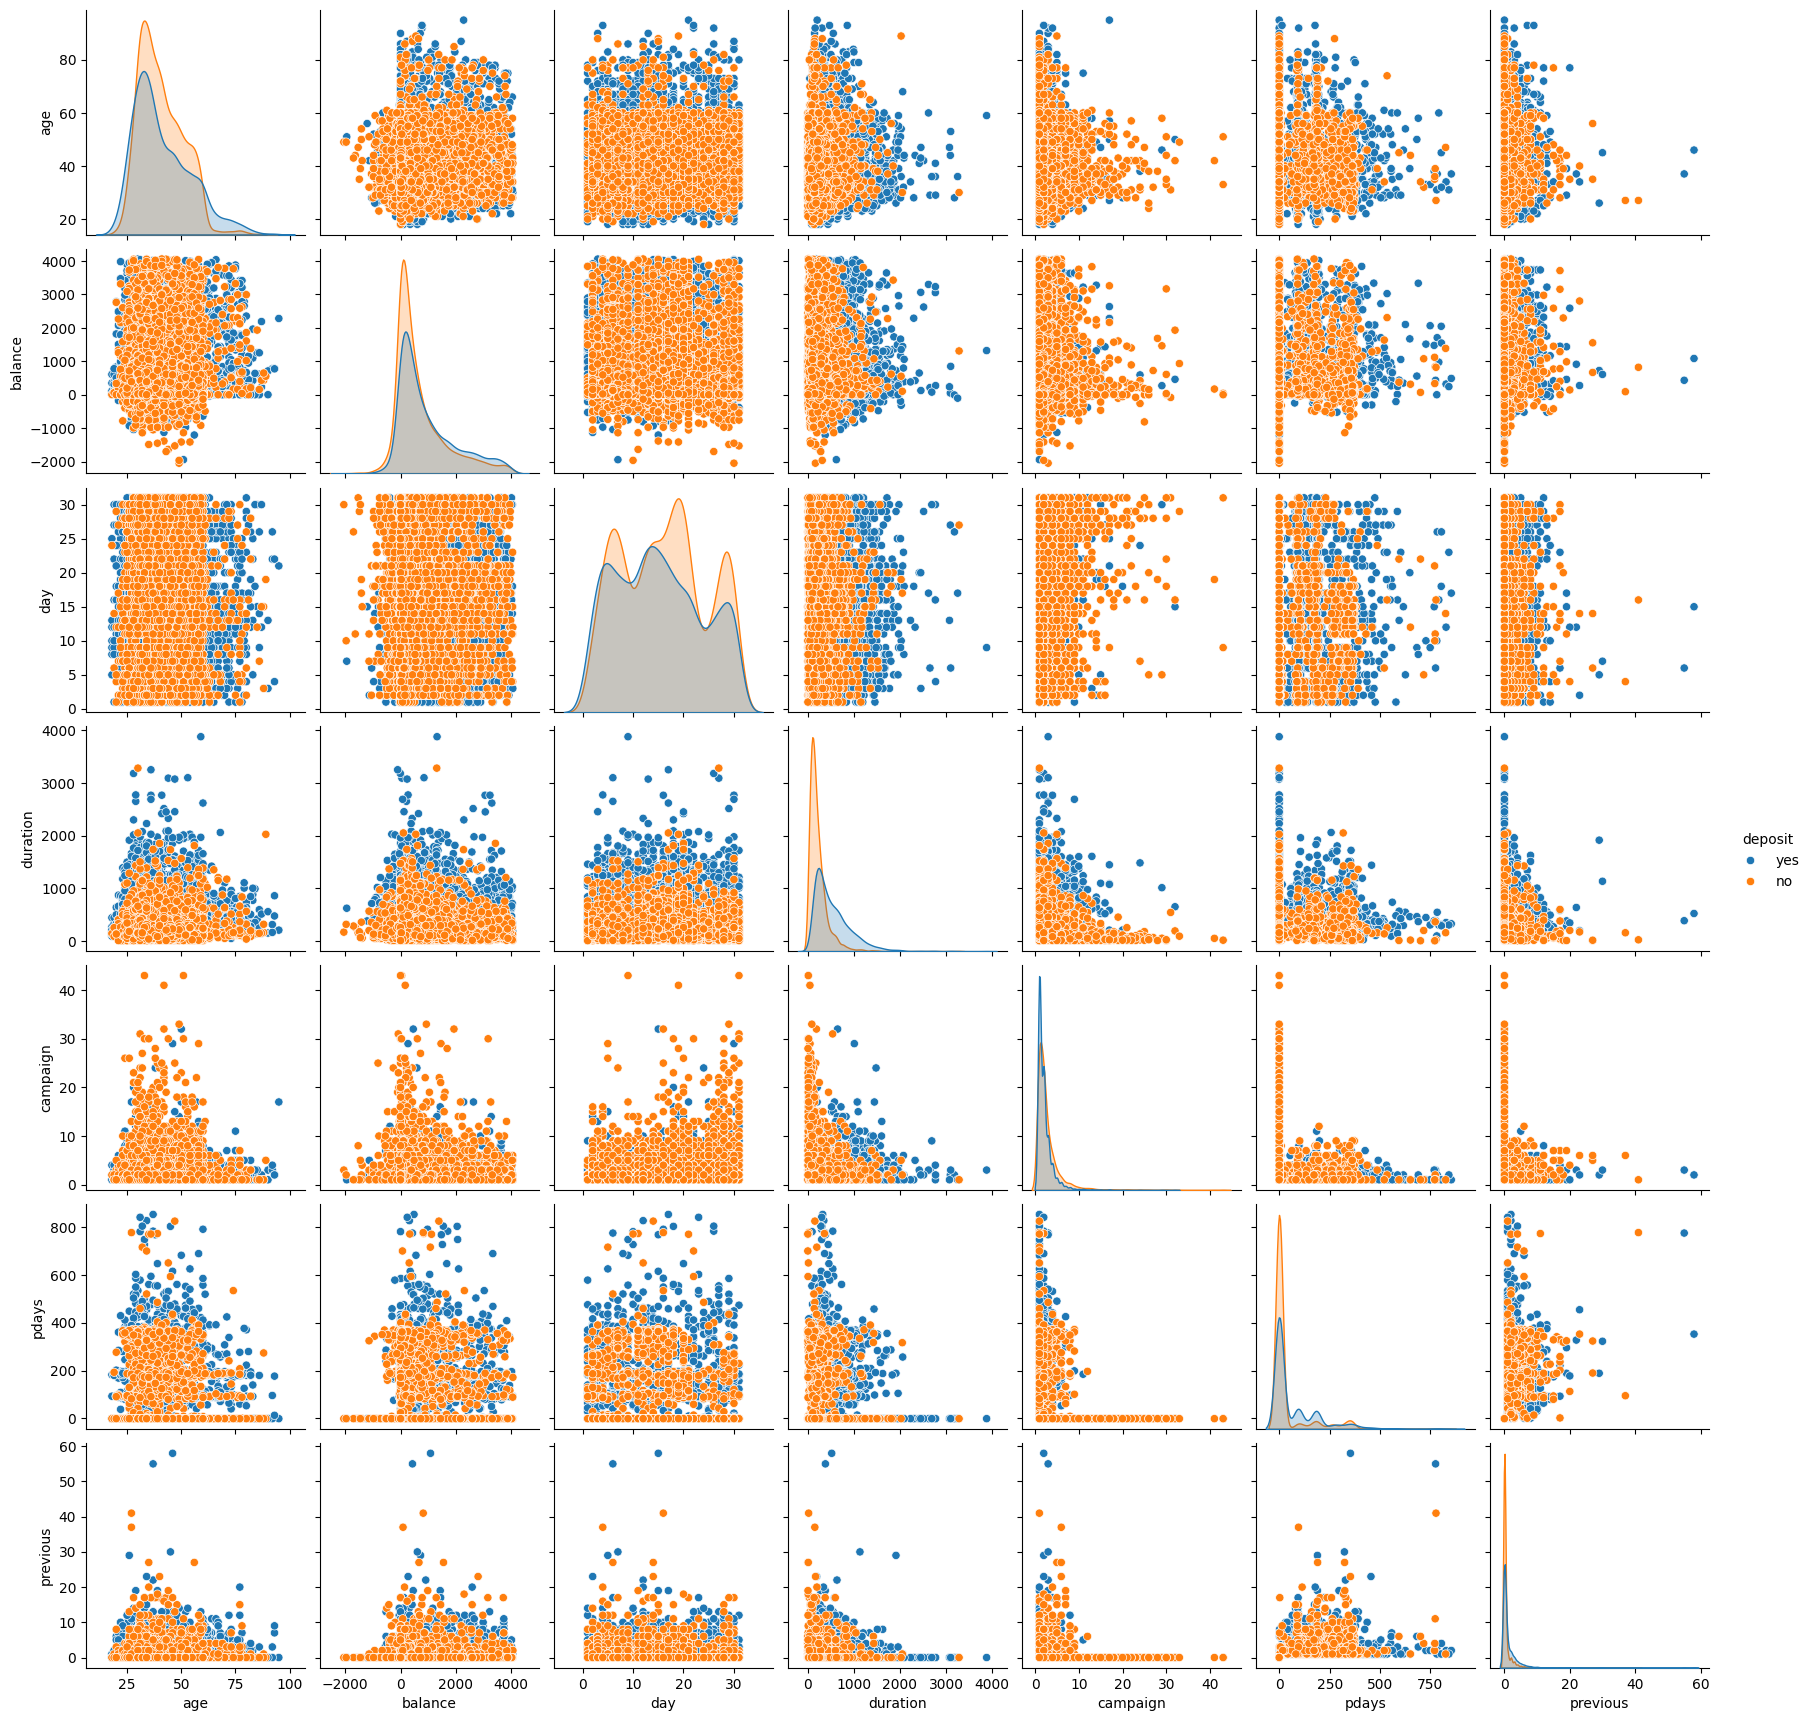

In [19]:
plt.figure()
sns.pairplot(df_bank, hue= 'deposit')
plt.show()

Визуализация подтверждает вышеуказанные выводы,  а также говорит о наличии выбросов почти в каждом признаке. 

### Задания 4 и 5

Рассчитаем **описательные статистики** для **категориальных** переменных

In [20]:
df_bank.describe(include='object')

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424

Убираем целевой признак перед визуализацией

In [21]:
types = df_bank.dtypes
cat_features = list(types[types == 'object'].index)
cat_features = cat_features[0:9]
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

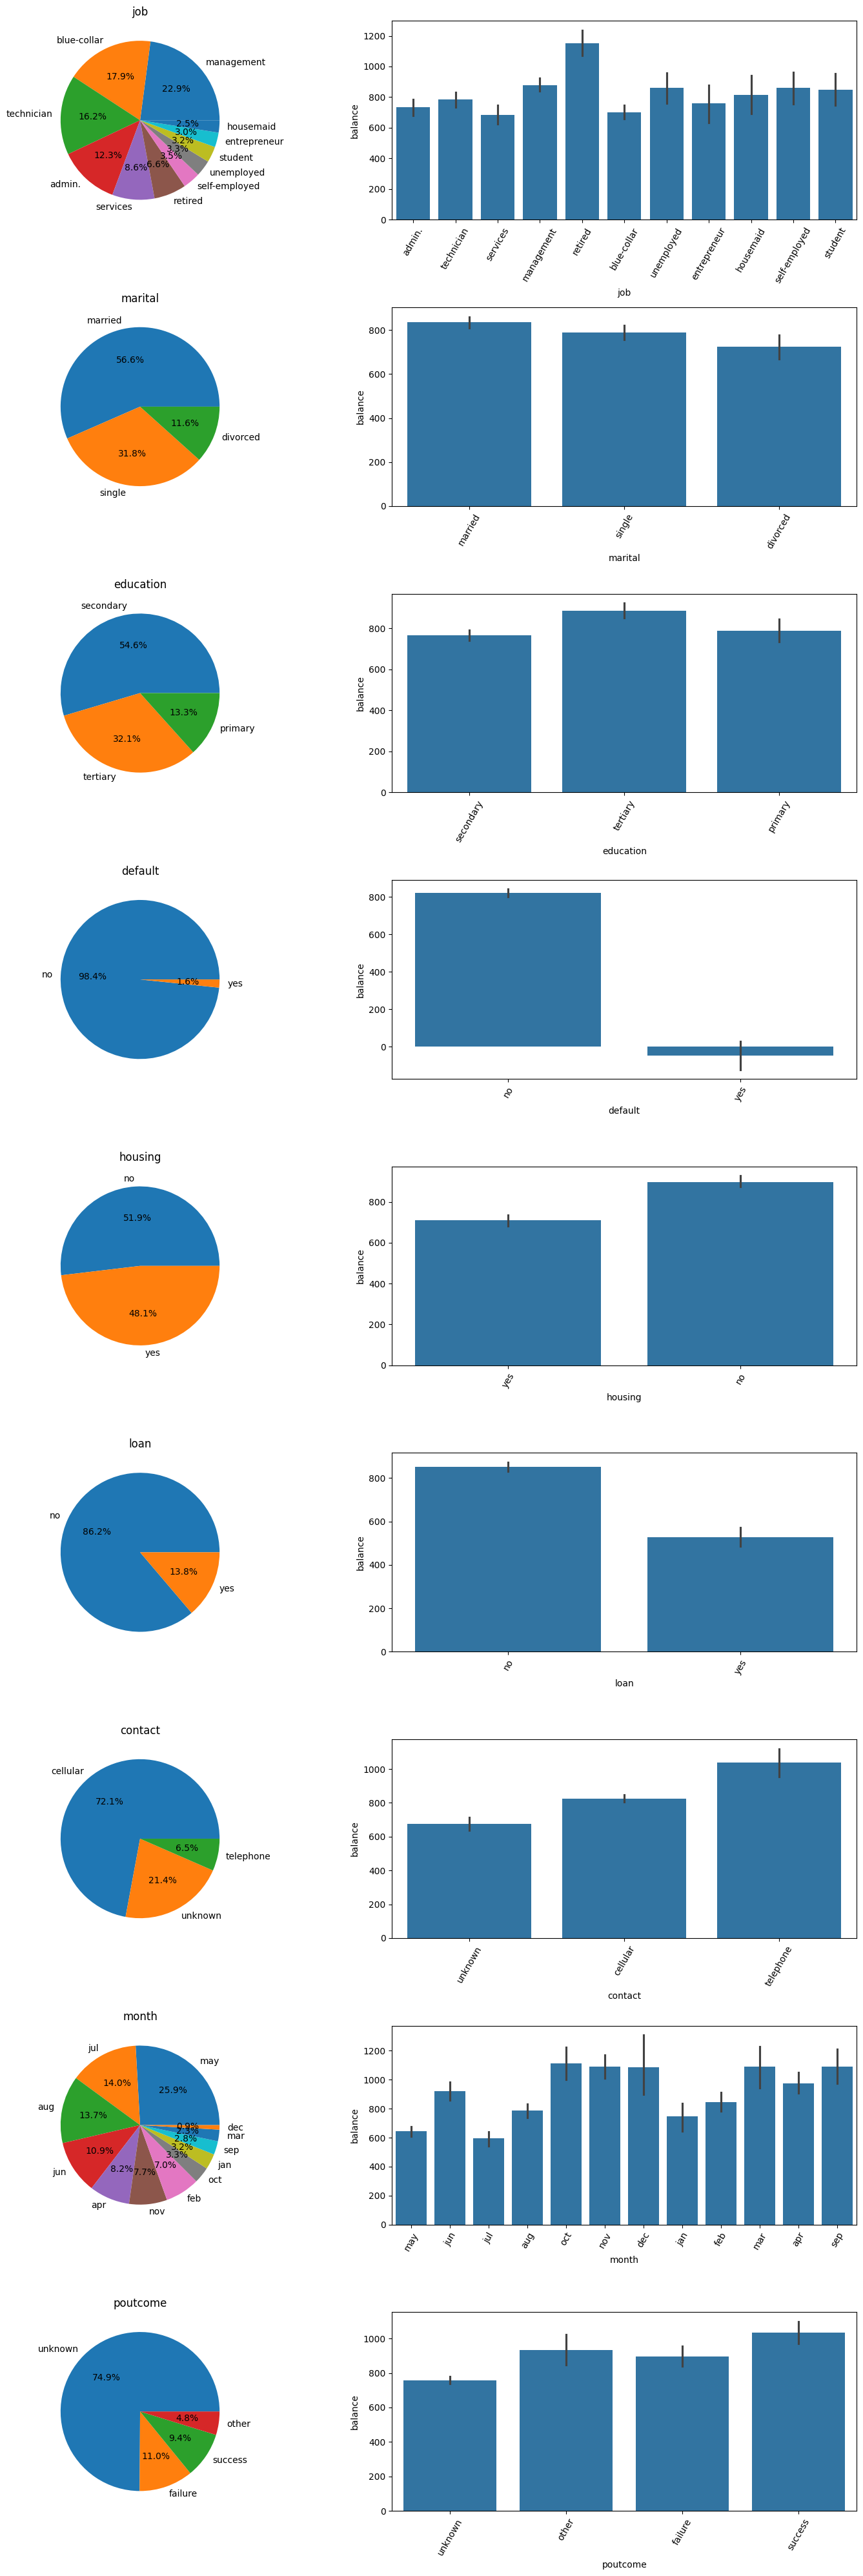

In [22]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим пирог для процентного соотношения каждой из категорий в данных
    count_data = df_bank[feature].value_counts().rename(feature)
    axes[i][0].pie(count_data, autopct='%.1f%%', labels=count_data.index)
    axes[i][0].set_title(feature)
    #Строим столбчатую диаграмму соотношения balance от представленных категорий
    mean_barplot = sns.barplot(data=df_bank, x=feature, y='balance', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков


**Выводы** по категоральным признакам:
- признак **martial** можно унифицировать до 2 значений, **объединив devorced и single**;
- признак **defoult** сильно **не сбалансирован**, целесообразно его **удалить** целиком;
- также целесообразно рассмотреть возможность **удаления** признака **loan**, поскольку в нем около **86 %** одинаковых значений;
- в признаке **contact** необходимо **преобразовать** значение **unknown**, поскольку оно неинформативно;

### Задание 6

Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач

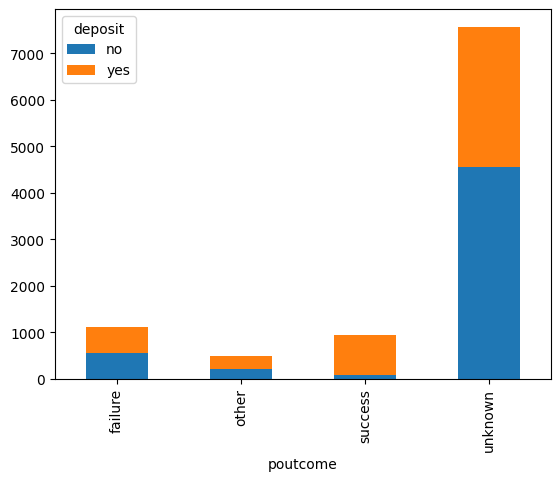

In [23]:
better = df_bank.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
better.plot(kind='bar', stacked=True);

### Задание 7

Узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит

In [24]:
df_bank.groupby('month')['deposit'].value_counts(normalize=False).unstack().sort_values(by='no', ascending=False)

deposit    no  yes
month             
may      1776  841
jul       836  582
aug       775  610
jun       606  498
nov       456  324
feb       323  386
apr       317  513
jan       194  125
oct        62  273
sep        46  232
mar        24  213
dec         9   84

Результаты анализа говорят, что в **мае** чаще всего (в два раза по сравнению со 2 местом) **отказывались** открыть депозит в банке

### Задание 8

Создадим **возрастные группы** и определим, в каких группах **более склонны открывать депозит**, чем отказываться от предложения

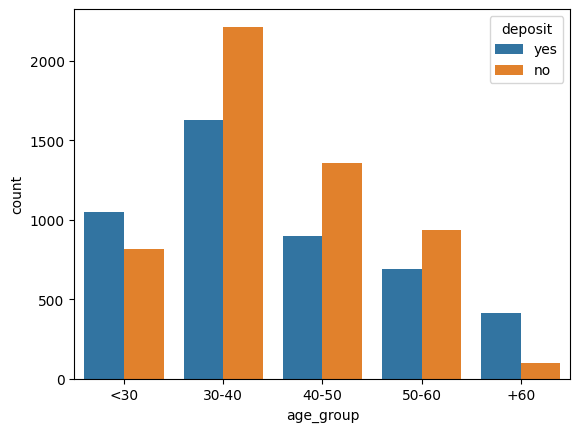

In [25]:
df_bank['age_group'] = pd.cut(df_bank['age'], [0, 30, 40 ,50 ,60, 9999], labels = ['<30', '30-40', '40-50', '50-60', '+60'])
sns.countplot(data=df_bank, x='age_group', hue='deposit');

Анализ возраста клиентов свидетельствует о том, что **клиенты младше 30 и старше 60** более склонны оформлять депозит в банке

### Задания 9 и 10

Построим визуализации для **открывших** и **неоткрывших** депозит в зависимости от **семейного статуса**

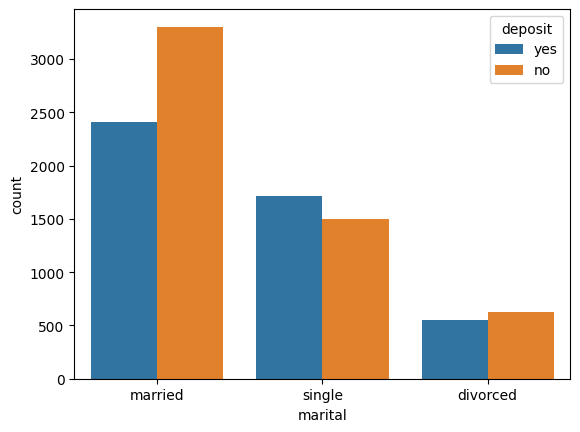

In [26]:
sns.countplot(data=df_bank, x='marital', hue='deposit');

**Клиенты,  состоящие в браке менее склонны** оформлять депозит по сравнению с иными категориями

Построим визуализации **для открывших и неоткрывших депозит** в зависимости от **образования**

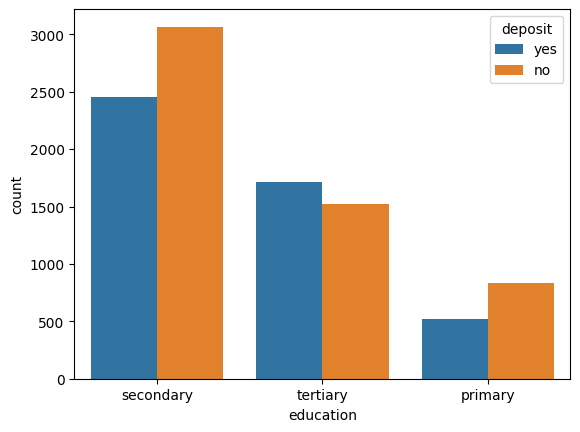

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(data=df_bank, x='education', hue='deposit');

**Клиенты банка со средним образованием чаще оформляют депозит**, чем представители иного уровня образования

Построим визуализации **для открывших и неоткрывших депозит** в зависимости от вида **профессиональной занятости**

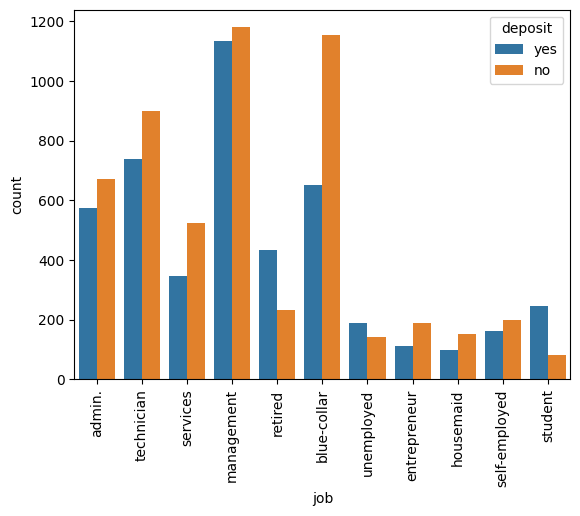

In [28]:
df_bank['job'].value_counts()
sns.countplot(data=df_bank, x='job', hue='deposit');
plt.xticks(rotation = 90);

Анализ свидетельствует о том, что **пенсионеры и студенты чаще оформляют депозит**. Бросается в глаза **отрицательное отношение к депозиту "голубых воротничков"**

### Задание 11

Построим **сводную таблицу**, чтобы определить люди с каким **образованием и семейным статусом** наиболее **многочисленны**
(если рассматривать тех, кто открыл депозит)

In [29]:
agree_mask = df_bank[df_bank['deposit'] == 'yes']
disagree_mask = df_bank[df_bank['deposit'] == 'no']
table_agree = pd.crosstab(agree_mask['marital'], agree_mask['education'])
display(table_agree)
table_disagree = pd.crosstab(disagree_mask['marital'], disagree_mask['education'])
display(table_disagree)

education  primary  secondary  tertiary
marital                                
divorced        96        283       174
married        339       1289       784
single          82        879       755

education  primary  secondary  tertiary
marital                                
divorced        91        370       163
married        641       1830       832
single         100        866       531

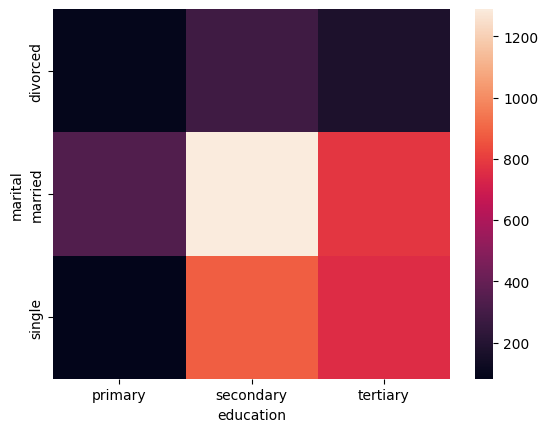

In [30]:
sns.heatmap(table_agree);

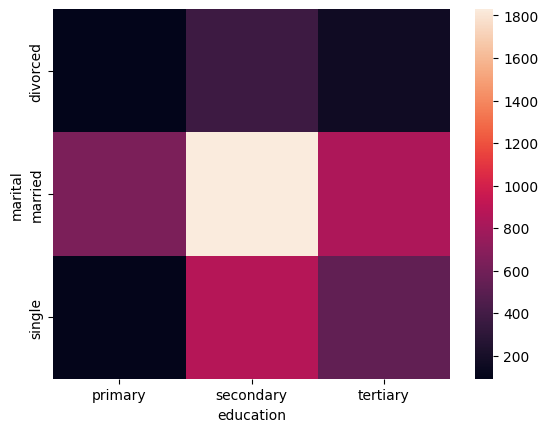

In [31]:
sns.heatmap(table_disagree);

Клиенты, **состоящие в браке и имеющие среднее образование являются самыми многочисленными**, относительно остальных. Это характерно как для лиц, оформивших депозит, так и не оформивших.

## Часть 3: преобразование данных

### Задание 1

Преобразуем уровни **образования** с помощью **LabelEncoder()**

In [32]:
# преобразуйте уровни образования
label_encoder = LabelEncoder()
df_bank['education'] = label_encoder.fit_transform(df_bank['education'])

In [33]:
df_bank['education'].sum()

11995

Аналогично поступим с **age_group**

In [34]:
df_bank['age_group'] = label_encoder.fit_transform(df_bank['age_group'])

### Задания 2 и 3

Преобразуем **бинарные переменные** в представление из нулей и единиц

In [35]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_bank['deposit'] = df_bank['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [36]:
df_bank['default'] = df_bank['default'].apply(lambda x: 1 if x == 'yes' else 0)

In [37]:
df_bank['housing'] = df_bank['housing'].apply(lambda x: 1 if x == 'yes' else 0)

In [38]:
df_bank['loan'] = df_bank['loan'].apply(lambda x: 1 if x == 'yes' else 0)

Вычислим среднее арифметическое для каждой из получившихся переменных, сложив три результата и в качестве ответа впишим итог, округлив его до трёх знаков после точки-разделителя.

In [39]:
(df_bank['housing'].mean() + df_bank['default'].mean() + df_bank['loan'].mean()).__round__(3)

0.635

### Задание 4

Создадим **дамми-переменные**

In [40]:
df_dummies = pd.get_dummies(df_bank, columns=['job', 'marital', 'contact','month', 'poutcome'])

### Задания 5 и 6

Построим **корреляционную матрицу** и оценим данные на предмет наличия **мультиколлинеарности**

<Axes: >

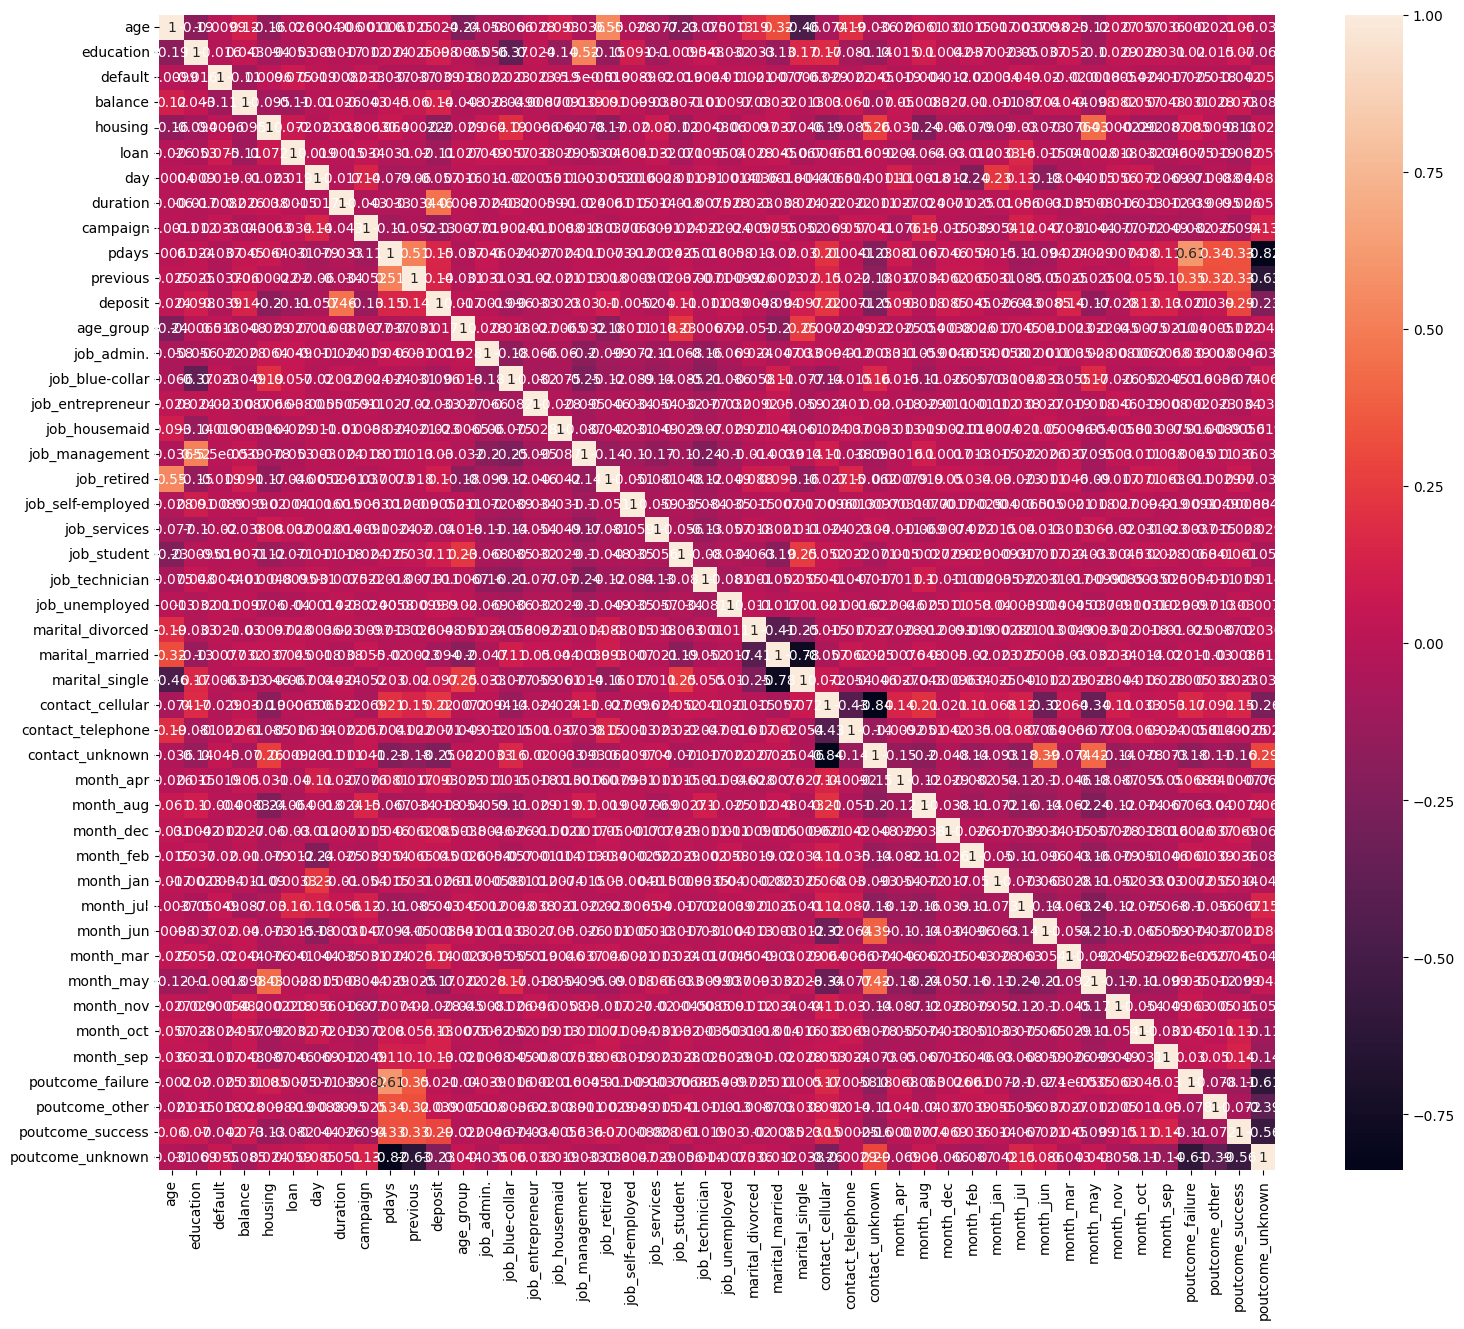

In [41]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(18, 15))
sns.heatmap(df_dummies.corr(), annot=True, ax=ax1)

Найдём **коррелированные пары** с помощью удобной **функции**:

In [42]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr_pairs = get_top_abs_correlations(df_dummies, 30)
corr_pairs

contact_cellular  contact_unknown      0.837885
pdays             poutcome_unknown     0.824031
marital_married   marital_single       0.779038
previous          poutcome_unknown     0.628346
pdays             poutcome_failure     0.608719
poutcome_failure  poutcome_unknown     0.606736
poutcome_success  poutcome_unknown     0.555044
age               job_retired          0.545524
education         job_management       0.518735
pdays             previous             0.513708
age               marital_single       0.464737
duration          deposit              0.457818
housing           month_may            0.432605
contact_cellular  contact_telephone    0.425010
contact_unknown   month_may            0.415598
marital_divorced  marital_married      0.414273
contact_unknown   month_jun            0.388312
poutcome_other    poutcome_unknown     0.386326
education         job_blue-collar      0.371796
previous          poutcome_failure     0.347800
pdays             poutcome_other       0

In [43]:
data = corr_pairs.reset_index()
df_bank_corr = data.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
df_bank_corr


feature_1          feature_2  correlation
0   contact_cellular    contact_unknown     0.837885
1              pdays   poutcome_unknown     0.824031
2    marital_married     marital_single     0.779038
3           previous   poutcome_unknown     0.628346
4              pdays   poutcome_failure     0.608719
5   poutcome_failure   poutcome_unknown     0.606736
6   poutcome_success   poutcome_unknown     0.555044
7                age        job_retired     0.545524
8          education     job_management     0.518735
9              pdays           previous     0.513708
10               age     marital_single     0.464737
11          duration            deposit     0.457818
12           housing          month_may     0.432605
13  contact_cellular  contact_telephone     0.425010
14   contact_unknown          month_may     0.415598
15  marital_divorced    marital_married     0.414273
16   contact_unknown          month_jun     0.388312
17    poutcome_other   poutcome_unknown     0.386326
18         education    job_blue-collar     0.371796
19          previous   poutcome_failure     0.347800
20             pdays     poutcome_other     0.338049
21  contact_cellular          month_may     0.337438
22          previous   poutcome_success     0.328978
23             pdays   poutcome_success     0.326215
24  contact_cellular          month_jun     0.319383
25          previous     poutcome_other     0.318888
26               age    marital_married     0.316681
27   contact_unknown   poutcome_unknown     0.291242
28           deposit   poutcome_success     0.288491
29  contact_cellular   poutcome_unknown     0.264559

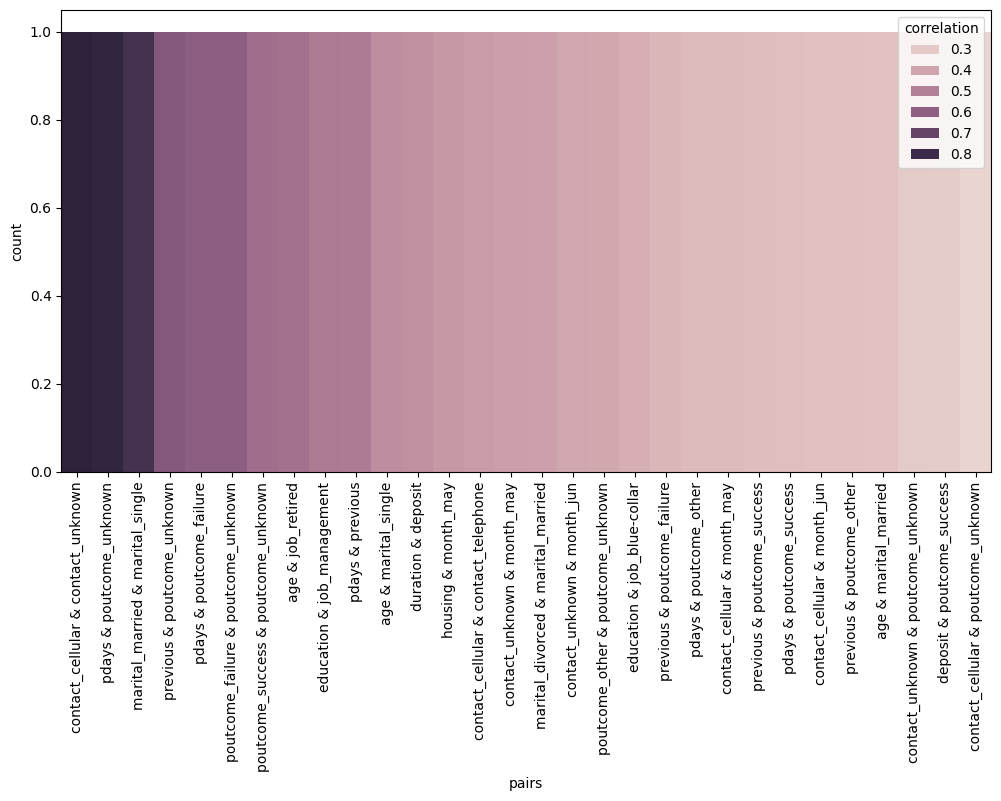

In [44]:
df_bank_corr['pairs'] = df_bank_corr['feature_1'] + ' & ' + df_bank_corr['feature_2']
df_bank_corr
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
sns.countplot(data=df_bank_corr, x='pairs', hue='correlation', width=1, ax=axes);
plt.xticks(rotation = 90);

К **наиболее коррелирующим** можно отнести следующие **пары**:
- contact_cellular	contact_unknown;
- pdays	poutcome_unknown;
- marital_married	marital_single.

**Наибольшая** корреляция **с целевой переменной** наблюдается у признака **duration**.
**Мультикорреляции** не обнаружено.

### Задания 7 и 8

Разделим данные на тренировочные и тестовые

In [45]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [46]:
y_test.shape
y_test.mean().__round__(2)


0.46

### Задание 9

**Отбираем 15** наиболее подходящих для ML признаков с помощью **SelectKBest**

In [47]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
predictors = selector.get_feature_names_out()

### Задание 10

Нормализуем предикты с помощью **minmaxsxaler**

In [48]:
col_names = list(predictors)
X_train = X_train[col_names]
X_test = X_test[col_names]

In [49]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
X_test_scaled[:,0].mean().__round__(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

Обучим **логистическую регрессию** и рассчитаем метрики качества

In [51]:
# обучите логистическую регрессию и рассчитайте метрики качества
linear_model = LogisticRegression(solver='sag',random_state=42, max_iter=1000)
linear_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [52]:
#Делаем предсказание для тестовой выборки
y_test_pred = linear_model.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



**Логистическая регрессия** показала **неплохой результат**, при этом, модель не переобучена. Но попробуем более сложные методы

### Задания 2,3,4

In [53]:
# обучим решающие деревья, настроим максимальную глубину
dt_df_bank = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
#Обучаем дерево решений
dt_df_bank.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [54]:
y_train_pred = dt_df_bank.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = dt_df_bank.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



**Дерьвья решений с незаданной глубиной** показывает явное **переобучение**, необходимо подобрать **оптимальные гипермараметры** для модели

### Задание 5

In [55]:
# подберем оптимальные параметры с помощью gridsearch
param_grid = {'max_depth': list(np.linspace(1, 30, 50, dtype=int))
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 734 ms
Wall time: 11 s
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      3634
           1       0.84      0.75      0.79      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1790
           1       0.80      0.74      0.77      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.79      0.79      3335
weighted avg       0.80      0.80      0.80      3335

Наилучшие значения гиперпараметров: {'max_depth': 6}


С помощью **GridSearchCV** были подобрана **оптимальная глубина**, переобучение **ликвидировано**. Подберем дополнительные гиперпараметры

In [56]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,
    scoring='f1', 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_tree.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 219 ms
Wall time: 730 ms
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      3634
           1       0.77      0.88      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.83      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1790
           1       0.74      0.84      0.79      1545

    accuracy                           0.79      3335
   macro avg       0.79      0.79      0.79      3335
weighted avg       0.80      0.79      0.79      3335

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [57]:
# обучим на наших данных случайный лес
#Создаём объект класса случайный лес
rf_df_bank = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_df_bank.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_test_pred = rf_df_bank.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



По сравнению с вышеуказанным **GridSearchCV** метрики **RandomForest улучшились**, переобучения так же не наблюдается 

### Задания 2 и 3

In [58]:
# Используем для классификации градиентный бустинг и сравним качество со случайным лесом
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5,
    min_samples_leaf=5,#максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred_gb = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



**Качество моделей**, обученных с помощью градиентного бустинга и случайного леса почти **не отличается**. **Небольшое преимущество** наблюдается у **случайного леса**

### Задание 4

In [59]:
# Объединим уже известные алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('gb', GradientBoostingClassifier(
    loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5,
    min_samples_leaf=5,#максимальная глубина дерева
    random_state=42 #генератор случайных чисел
    )),
    ('lr', LogisticRegression(
    solver='sag',
    random_state=42, 
    max_iter=1000
    )),
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
    ))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

In [60]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике
print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

Осуществим отбор **наиболее значимых** для модели GradientBoosting **признаков**

In [61]:
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

Тоже самое, только для GradientBoosting с **заданными параметрами**

In [62]:
estimator = gb
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

Отобразим результаты на графике

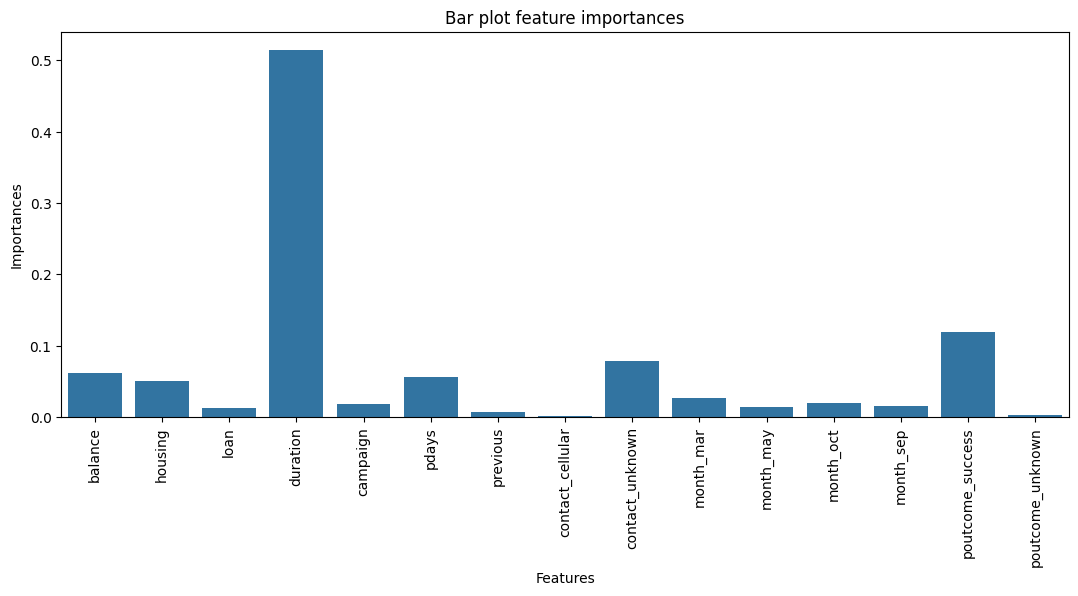

In [63]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
plt.xticks(rotation = 90);

### Задания 6,7,8

In [64]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X, y, cv=3, scoring="f1", n_jobs=-1).mean()
  

  return score

In [65]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-09-17 21:35:05,538] A new study created in memory with name: RandomForestClassifier
[I 2024-09-17 21:35:11,478] Trial 0 finished with value: 0.7735114992188293 and parameters: {'n_estimators': 150, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7735114992188293.
[I 2024-09-17 21:35:16,714] Trial 1 finished with value: 0.7730059529225922 and parameters: {'n_estimators': 168, 'max_depth': 21, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7735114992188293.
[I 2024-09-17 21:35:22,302] Trial 2 finished with value: 0.7710377720747177 and parameters: {'n_estimators': 190, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7735114992188293.
[I 2024-09-17 21:35:27,497] Trial 3 finished with value: 0.767596541127367 and parameters: {'n_estimators': 167, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7735114992188293.
[I 2024-09-17 21:35:31,847] Trial 4 finished with value: 0.7865283941330444 and parameters: {'n_e

CPU times: total: 18.8 s
Wall time: 1min 19s


In [66]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 115, 'max_depth': 20, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.79


In [67]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3634
           1       0.87      0.90      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



**Optuna** показала **хорошие результаты**, вместе с тем, если сравнивать тренировочную и тестовую выборку, то наблюдается небольшое **переобучение**

In [68]:
optuna.visualization.plot_optimization_history(study, target_name="accuracy")

In [69]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

По итогам обучения модели различными методами можно сделать **вывод**, что **наилучший результат** показывают **градиентный бустинг и случайный лес**, вместе с тем, **метрики отличаются незначительно** в сравнении с остальными моделями. Вероятнее всего дело в том, что окончательная **выборка данных оказалась небольшой** и более продвинутые методы машинного обучения не могут полностью реализовать свой ресурс.

In [70]:
print(X_train_scaled.shape)
print(df_bank.shape)

y_train_pred.shape

(6770, 15)
(10105, 18)


(6770,)

Обучим **всю** нашу выборку на Случайном лесе

In [71]:
# обучим на наших данных случайный лес
#Создаём объект класса случайный лес
rf_df_bank = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5, #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_df_bank.fit(X, y)

#Делаем предсказание класса
prediction = rf_df_bank.predict(X)


In [72]:
df_bank['prediction_deposit'] = prediction

In [73]:
print(df_bank['deposit'].value_counts())
print(df_bank['prediction_deposit'].value_counts())

0    5424
1    4681
Name: deposit, dtype: int64
0    5189
1    4916
Name: prediction_deposit, dtype: int64
